In [1]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_key = nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_value = nn.Linear(d_in,d_out,bias=qkv_bias)
        self.out_proj = nn.Linear(d_out,d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask",torch.triu(torch.ones(context_length,context_length),diagonal=1))

    def forward(self,x):
        b,num_tokens,d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        keys = keys.view(b,num_tokens,self.num_heads,self.head_dim)
        queries = queries.view(b,num_tokens,self.num_heads,self.head_dim)
        values = values.view(b,num_tokens,self.num_heads,self.head_dim)
        keys = keys.transpose(1,2)
        queries = queries.transpose(1,2)
        values = values.transpose(1,2)
        attn_scores = queries @ keys.transpose(2,3)
        mask_bool = self.mask.bool()[:num_tokens,:num_tokens]
        attn_scores.masked_fill_(mask_bool,-torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5,dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = (attn_weights @ values).transpose(1,2)
        context_vec = context_vec.contiguous().view(b,num_tokens,self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec

class GPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"],cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            * [TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"],cfg["vocab_size"],bias=False
        )
    def forward(self,in_idx):
        batch_size,seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len,device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    
class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def forward(self,x):

        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self,x):
        mean = x.mean(dim=-1,keepdim=True)
        var = x.var(dim=-1,keepdim=True,unbiased=False)
        norm_x = (x-mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
    
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self,x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x,3))
        ))

class FeedForward(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"]),
        )
    
    def forward(self,x):
        return self.layers(x)

class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self,layer_sizes,use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0],layer_sizes[1]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1],layer_sizes[2]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2],layer_sizes[3]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3],layer_sizes[4]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4],layer_sizes[5]),
                          GELU())
        ])

    def forward(self,x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [2]:
import numpy as np

def assign(left,right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
                         "Right: {right.shape}"
                         )
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [3]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1) 
            idx_next = torch.multinomial(probs, num_samples=1)

        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True) 

        if idx_next == eos_id: 
            break

        idx = torch.cat((idx, idx_next), dim=1) 

    return idx

def text_to_token_ids(text,tokenizer):
    encoded = tokenizer.encode(text,allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids,tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [4]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    # The book originally contained this unnecessary "else" clause:
    #else:
    #    with open(file_path, "r", encoding="utf-8") as file:
    #        text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [5]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [6]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


In [7]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [8]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [9]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [10]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [11]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [12]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [13]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [14]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [15]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [16]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [17]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [18]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [19]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [20]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [21]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [22]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


In [23]:
device = torch.device("mps")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is much faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")

print("Device:", device)

Device: mps


In [24]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [25]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [26]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [27]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

In [28]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='mps:0')


In [29]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='mps:0')


In [30]:
from gpt_download import download_and_load_gpt2


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


In [31]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [32]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [33]:
response_text = (
    generated_text[len(input_text):].strip()
)
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


In [34]:
def calc_loss_batch(input_batch,target_batch,model,device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1),target_batch.flatten()
    )
    return loss

In [35]:
def calc_loss_loader(data_loader,model,device,num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches == None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches,len(data_loader))
    for i,(input_bath,target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_bath,target_batch,model,device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [36]:
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader,model,device,num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader,model,device,num_batches=eval_iter
        )
    model.train()
    return train_loss,val_loss

In [37]:
def generate_text_simple(model,idx,max_new_tokens,context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
            logits = logits[:,-1,:]
            probas = torch.softmax(logits,dim=-1)
            idx_next = torch.argmax(probas,dim=-1,keepdim=True)
            idx = torch.cat((idx,idx_next),dim=1) 
    return idx

In [38]:
def generate_and_print_sample(model,tokenizer,device,start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context,tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,idx=encoded,
            max_new_tokens=50,context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids,tokenizer)
    print(decoded_text.replace("\n"," "))
    model.train()

In [39]:
def train_model_simple(model,train_loader,val_loader,optimizer,device,num_epochs,eval_freq,eval_iter,start_context,tokenizer):
    train_losses,val_losses,track_tokens_seen = [],[],[]
    tokens_seen,global_step = 0,-1
    
    for epoch in range(num_epochs):
        model.train()
        for input_batch,target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch,target_batch,model,device
            )
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss,val_loss = evaluate_model(
                    model,train_loader,val_loader,device,eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}):"
                      f"Train loss {train_loss:.3f},"
                      f"Val loss {val_loss:.3f}"
                      )
        generate_and_print_sample(
            model,tokenizer,device,start_context
        )
    return train_losses,val_losses,track_tokens_seen

In [40]:
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader,model,device,num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader,model,device,num_batches=5
    )

print("Training loss:",train_loss)
print("Validation loss:",val_loss)

Training loss: 19.87874412536621
Validation loss: 19.92352752685547


In [41]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    model.parameters(),lr=0.00005,weight_decay=0.1
)
num_epochs = 2

train_losses,val_losses,tokens_seen = train_model_simple(
    model,train_loader,val_loader,optimizer,device,
    num_epochs=num_epochs,eval_freq=5,eval_iter=5,
    start_context=format_input(val_data[0]),tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")


Ep 1 (Step 000000):Train loss 19.995,Val loss 19.811
Ep 1 (Step 000005):Train loss 19.228,Val loss 19.256
Ep 1 (Step 000010):Train loss 18.891,Val loss 18.731
Ep 1 (Step 000015):Train loss 18.197,Val loss 18.227
Ep 1 (Step 000020):Train loss 17.731,Val loss 17.734
Ep 1 (Step 000025):Train loss 17.262,Val loss 17.257
Ep 1 (Step 000030):Train loss 16.598,Val loss 16.789
Ep 1 (Step 000035):Train loss 16.266,Val loss 16.352
Ep 1 (Step 000040):Train loss 15.851,Val loss 15.932
Ep 1 (Step 000045):Train loss 15.339,Val loss 15.503
Ep 1 (Step 000050):Train loss 15.015,Val loss 15.050
Ep 1 (Step 000055):Train loss 14.427,Val loss 14.569
Ep 1 (Step 000060):Train loss 13.920,Val loss 14.014
Ep 1 (Step 000065):Train loss 13.382,Val loss 13.448
Ep 1 (Step 000070):Train loss 12.591,Val loss 12.924
Ep 1 (Step 000075):Train loss 12.130,Val loss 12.429
Ep 1 (Step 000080):Train loss 11.756,Val loss 11.948
Ep 1 (Step 000085):Train loss 11.360,Val loss 11.461
Ep 1 (Step 000090):Train loss 10.939,Val loss 

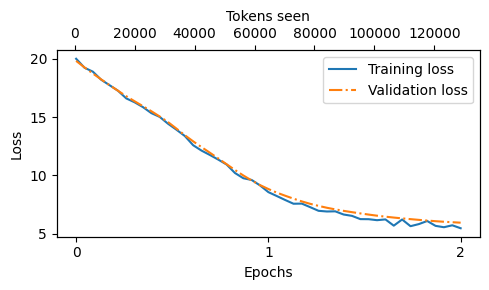

In [42]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen,tokens_seen,train_losses,val_losses):
    fig,ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen,train_losses,label="Training loss")
    ax1.plot(epochs_seen,val_losses,linestyle="-.",label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen,train_losses,alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0,num_epochs,len(train_losses))
plot_losses(epochs_tensor,tokens_seen,train_losses,val_losses)

In [43]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model = model,
        idx = text_to_token_ids(input_text,tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids,tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace('### Response:','')
        .strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("--------------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence s

In [44]:
from tqdm import tqdm

for i,entry in tqdm(enumerate(test_data),total=len(test_data)):
    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx = text_to_token_ids(input_text,tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )

    generated_text = token_ids_to_text(token_ids,tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace('### Response:','')
        .strip()
    )

    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json","w") as file:
    json.dump(test_data,file,indent=4)

100%|██████████| 110/110 [1:00:01<00:00, 32.74s/it]


In [45]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': "sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence

In [46]:
import re

file_name = f"{re.sub(r'[ ()]','',CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(),file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth


In [47]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError(
        "Ollama not running. Launch ollama before proceeding."
    )
print("Ollama running:",check_if_running("ollama"))

Ollama running: True


In [48]:
import urllib.request

def query_model(
        prompt,
        model="llama3",
        url="http://localhost:11434/api/chat"
):
    data = {
        "model" : model,
        "messages" : [{"role":"user","content":prompt}],
        "options" :{
            "seed":123,
            "temperature":0,
            "num_ctx":2048
        }
    }

    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )

    request.add_header("Content-Type","application/json")

    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    
    return response_data

In [49]:
model = "llama3"
result = query_model("What do Llamas eat?",model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

In [50]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}`"
        f"and correct output `{entry['output']}`"
        f"score the model response `{entry['model_response']}`"
        f"on a scale from 0 to 100,where 100 is the best score."
    )

    print("\nDataset response:")
    print(">>",entry['output'])
    print("\nModel response:")
    print(">>",entry["model_response"])
    print("\nScore:")
    print(">>",query_model(prompt))
    print("\n----------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentence sentenc

In [51]:
def generate_model_scores(json_data,json_key,model="llama3"):
    scores = []
    for entry in tqdm(json_data,desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}`"
            f"and correct output `{entry['output']}`"
            f"score the model response `{entry['model_response']}`"
            f"on a scale from 0 to 100,where 100 is the best score."
            f"Respond with the integer number only."
        )
        score = query_model(prompt,model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue
    return scores

In [52]:
scores = generate_model_scores(test_data,"model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores) / len(scores) :.2f}\n")

Scoring entries:  25%|██▌       | 28/110 [00:47<03:41,  2.70s/it]

Could not convert score: I'd be happy to help!

Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Define the term 'kinetic energy'.`and correct output `Kinetic energy is the energy that an object possesses due to its motion.`score the model response

I would score this response as 100, since it accurately defines kinetic energy and provides a clear explanation.


Scoring entries:  31%|███       | 34/110 [00:59<02:37,  2.07s/it]

Could not convert score: I'd be happy to help!

### Model Response:
7 kilometers is 7000 meters.

### Score: 100


Scoring entries:  68%|██████▊   | 75/110 [02:04<01:47,  3.07s/it]

Could not convert score: I'd be happy to help!

The correct output for the given input "10, 2, 25, 16, 7" in descending order would be:

"25, 16, 10, 7, 2"

To score my response, I'll use the provided scale from 0 to 100. Since my response matches the correct output, I'd give myself a perfect score of:

**100**


Scoring entries:  71%|███████   | 78/110 [02:12<01:37,  3.04s/it]

Could not convert score: Here's my attempt at completing the request:

### Response:
Classify the following words by their grammatical categories: swim, beautiful, quickly

Swim: Verb
Beautiful: Adjective
Quickly: Adverb

### Score:
I would score this response as 100. The classification of each word is accurate and consistent with standard English grammar rules.


Scoring entries:  97%|█████████▋| 107/110 [03:05<00:06,  2.24s/it]

Could not convert score: I'd be happy to help!

The model response I would provide for the given instruction is:

### Instruction:
What is the past tense of 'think'?

### Output:
The past tense of 'think' is 'thought'.

Score: 100


Scoring entries:  98%|█████████▊| 108/110 [03:08<00:05,  2.66s/it]

Could not convert score: The classification of the sentence 'Please open the door.' is imperative.

Score: 100


Scoring entries: 100%|██████████| 110/110 [03:13<00:00,  1.76s/it]

Number of scores: 104 of 110
Average score: 78.67

